# **Data scientist technical test - Descartes Underwriting**
## *Coraline Mounier - 16/12/2021*

## I) INTRODUCTION

The aim of this project is to implement a supervised machine learning algorithm in order to make a prediction on the dataset Auto Insurance based on the Kaggle competition:
<a> https://www.kaggle.com/c/auto-insurance-fall-2017</a>. The dataset contains insurance claim statics on the customers, and was downloaded from 
<a>https://github.com/descartes-underwriting/data-scientist-technical-test</a> and is made of two csv files :
- train_auto.csv : the dataset to train our machine learning algorithm
- test_auto.csv : the dataset on which we want to make a prediction

The target is `TARGET_FLAG`. Files `SHELL_AUTO` and `MEAN_AUTO` are ignored for this project.

This work is organised in 5 parts :
 - **II) Importing datasets** : we make the required imports and quickly analyse train and test sizes and target properties.
 - **III) Preprocessing** : we deal with some preprocessing issues such as fill missing values, encode all numerical features as numbers, and harmonize notations of categorical features.
 - **IV) Exploratory data analysis** : we look into the distributions of feature values to discover patterns and get insights on each feature's predictive power. We also look at feature correlation.
 - **V) Model training** : first, we train a model on the whole dataset. As this gives unsatisfactory results, we downsample the dataset to get balanced target classes. We train three types of algorithms : Logistic Regression, Random Forest, Support Vector Machine (SVM). We use cross validation to compare their performances. We select the best model looking at accuracy and precision metrics.
 - **VI) Prediction on the test set** : we make the preprocessing transformations on the test set and predict target with selected model. The result is saved in a csv file named `test_predictions`.

## II) IMPORTING DATASETS

We start the project by importing the libraries and functions used in the project and importing the train and test datasets from the csv files. In the following, lines in the dataset corresponding to insurance claims will be referred to as samples.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate

In [94]:
# import train and test sets
df_auto_train = pd.read_csv('train_auto.csv', sep=",")
df_auto_test = pd.read_csv('test_auto.csv', sep=",")

#visualizing a part of the train set
df_auto_train.head(3)

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban


In [95]:
#visualizing a part of the test set
df_auto_test.head(3)

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,3,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,...,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
1,9,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,...,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
2,10,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,...,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural


In [5]:
# number of samples and features in train and test sets
print(df_auto_train.shape)
print(df_auto_test.shape)

(8161, 26)
(2141, 26)


The train dataset is made of 8161 samples while the test set is made of 2141 samples. For each, we have 26 columns including the sample index and the target feature `TARGET_FLAG`. `TARGET_FLAG` and `TARGET_AMT` are not given for the test set. Thus, we are left with 23 features that will be used as inputs to train our algorithm.

In [6]:
# range of target feature
set(list(df_auto_train['TARGET_FLAG']))

{0, 1}

The target feature is binary. We are facing a binary classification problem, which is why we chose to test three types of algorithms : Logistic Regression, Random Forest, SVM. 

Let us look now at the percentage of each class in the train set.

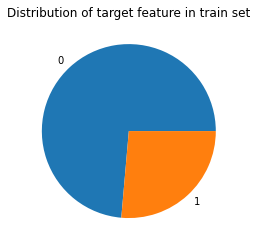

In [7]:
# distribution of target features in train set
plt.pie((df_auto_train["TARGET_FLAG"].value_counts()), labels = [0,1])
plt.title('Distribution of target feature in train set')
plt.show()

We are facing a binary classification problem with unbalanced target, with approximately 75% of samples in the class 0  and 25% in class 1.

## III) PREPROCESSING

In this section, before going further into feature analysis, we will deal with some preprocessing issues such as drop or fill missing values, make sure all numerical features are encoded as float or int, check coherence of values, and harmonize notations for categorical values. We start by looking at the different features and their types. 

In [8]:
df_auto_train.dtypes

INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME          object
PARENT1         object
HOME_VAL        object
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK        object
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM        object
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object

### III.1) Encoding of numerical features

The 4 features `INCOME`, `HOME_VAL`, `BLUEBOOK`, `OLDCLAIM` are not stored as float but they are in fact numerical features. We thus want to convert them into floats. If we look into the dataset, we see that the values of these features are saved as strings with dollars and comas. So, we implement a function `convert_to_float` that removes the '$' and ','.

In [9]:
def convert_to_float(x):
    # function to convert the data from INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM features to float
    # input : x is str with first caracter that should be '$' and ',' is used to indicate the thousands' position
    
    if x!=x:                                            # check NaN
        return x
    elif (x[0]!='$'):                                     # check right format
        print("input doesn't have required format")
    else:                 
        return float(x[1:].replace(',',''))

In [111]:
# converting the four columns in dataframe
for key in ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']:
    df_auto_train[key] = df_auto_train[key].transform(lambda x : convert_to_float(x))

In [112]:
#check new type (expect float)
df_auto_train.dtypes[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']]

INCOME      float64
HOME_VAL    float64
BLUEBOOK    float64
OLDCLAIM    float64
dtype: object

We save in 3 lists the names of all 23 features, of only numerical features and of only categorical features, which will be useful in the following work.

In [113]:
features_list = list(df_auto_train.keys()[3:])    # list of the 23 features
nb_features = len(features_list)
features_type = df_auto_train.dtypes              # their associated types

# list of numerical features
numerical_features = [key for key,value in features_type.items() if value != 'object'][3:]
# list of categorical features
categorical_features = [key for key,value in features_type.items() if value == 'object']
print('Numerical features : ' , numerical_features)
print('Categorical features : ', categorical_features)

Numerical features :  ['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE']
Categorical features :  ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY']


Now that we have corrected the types of numerical features, we can summerize the features in the training set. Among the 23 features, we have at our disposal :
- 13 numerical features : `KIDSDRIV`, `AGE`, `HOMEKIDS`, `YOJ`, `TRAVTIME`, `TIF`, `CLM_FREQ`, `MVR_PTS`, `CAR_AGE`, `INCOME`, `HOME_VAL`, `BLUEBOOK`, `OLDCLAIM`
- 10 categorical features : `PARENT1`, `MSTATUS`, `SEX`, `EDUCATION`, `JOB`, `CAR_USE`, `CAR_TYPE`, `RED_CAR`, `REVOKED`, `URBANICITY`

These features give personal information about the insured party (family, professional and financial situation), information about their car (age, color, model), about their use of the car (type and time of travel), and about their previous insurance claims (amount and frequency).

### III.2) Checking ranges of values for numerical features
Let's see the range of values by looking at minimum and maximum values for numerical features. Considering what the numerical features represent (age, number of kids, amount of previous claims, etc), we expect them to take positive values.

In [114]:
# minimum and maximum values for numerical features
for num_feat in numerical_features:
    data_feature = np.array(df_auto_train[num_feat])
    print(num_feat+' : min =', min(data_feature), ' max =',max(np.array(df_auto_train[num_feat])))

KIDSDRIV : min = 0  max = 4
AGE : min = 16.0  max = 81.0
HOMEKIDS : min = 0  max = 5
YOJ : min = 0.0  max = 23.0
INCOME : min = 0.0  max = 367030.0
HOME_VAL : min = 0.0  max = 885282.0
TRAVTIME : min = 5  max = 142
BLUEBOOK : min = 1500.0  max = 69740.0
TIF : min = 1  max = 25
OLDCLAIM : min = 0.0  max = 57037.0
CLM_FREQ : min = 0  max = 5
MVR_PTS : min = 0  max = 13
CAR_AGE : min = -3.0  max = 28.0


Ranges for numerical values seem all coherent except for the negative minimum value for the `CAR_AGE` feature. Let us see how many samples are impacted by negative values.

In [115]:
# look for negative values in numerical features
for num_feat in numerical_features:
    nb = df_auto_train[df_auto_train[num_feat] < 0].shape[0]
    if nb > 0:
        print('The feature '+num_feat+' has '+str(nb)+ ' negative incoherent values.')

The feature CAR_AGE has 1 negative incoherent values.


The proportion of incoherent `CAR_AGE` value is insignificant. We propose to simply replace this negative value by its absolute value.

In [116]:
# replacing negative values for numerical features by their absolute values
for num_feat in numerical_features:
    df_auto_train[num_feat] = df_auto_train[num_feat].transform(lambda x : abs(x) if x<0 else x)

### III.3) Checking values for categorical features

Now let's look at the values taken by categorical features.

In [117]:
# values for categorical features
for num_feat in categorical_features:
    data_feature = list(df_auto_train[num_feat])
    print(num_feat+' : ', set(data_feature))

PARENT1 :  {'No', 'Yes'}
MSTATUS :  {'Yes', 'z_No'}
SEX :  {'z_F', 'M'}
EDUCATION :  {'PhD', 'Bachelors', 'z_High School', 'Masters', '<High School'}
JOB :  {nan, 'Manager', 'Clerical', 'Home Maker', 'Professional', 'Doctor', 'z_Blue Collar', 'Lawyer', 'Student'}
CAR_USE :  {'Private', 'Commercial'}
CAR_TYPE :  {'Van', 'Sports Car', 'Panel Truck', 'z_SUV', 'Pickup', 'Minivan'}
RED_CAR :  {'no', 'yes'}
REVOKED :  {'No', 'Yes'}
URBANICITY :  {'Highly Urban/ Urban', 'z_Highly Rural/ Rural'}


Values seem coherent, but some 'z_' are added at the beginning of some values. As they are meaningless, we propose to remove them for more readibility. We implement the following function `remove_z` to do so. We also make all string lower case in order to harmonize notations.

In [118]:
def remove_z(x):
    # function used to remove the 'z_' characters at the beginning of a string
    # input : x (str)
    # output : x if 'z_' is not at the beginning of x, else removes these first two characters
    
    if x!=x:                                            # check NaN
        return x
    elif len(x)>1 and x[:2]=='z_':
        return x[2:]
    else:
        return x

In [119]:
for cat_feat in categorical_features:
    # removing potential 'z_' characters in the categorical features using the previously defined function
    df_auto_train[cat_feat] = df_auto_train[cat_feat].transform(lambda x : remove_z(x))
    # making lower case
    df_auto_train[cat_feat] = df_auto_train[cat_feat].str.lower()

### III.4) Dealing with NaN values

Let us look if there are missing values in the dataset. We implement a function `nan_proportions` that will look for the presence of NaN in the dataset, and return the proportions of NaN per feature if some NaN are found. This will allow us to see which features have missing values and their proportions in order to decide wether to drop the features, drop the samples with missing values, or fill them using median or most represented value.

In [21]:
def nan_proportions(df):
    # function that looks for the presence of NaN in dataframe. 
    # If NaN were found in some columns, it returns the proportions of NaN per colum.
    # input : df = dataframe
    # output : NaN_props = sorted dictionary where keys are the column names where NaN were found, and values are
    #                      the ratio of number of NaN in the corresponding column over total number of lines
    
    n_samples = df.shape[0]     # number of lines in dataframe
    NaN_props = {}              # dictionary with proportions of NaN
    for key in list(df.keys()):                                # iteration over all columns
        df_nan = df[key].isna().value_counts().reset_index()   # counting NaN and non NaN values
        if df_nan.shape[0] > 1 :                                          # condition if NaN were detected
            NaN_props[key] = int(df_nan[df_nan['index']==True][key]) / n_samples  # computes NaN proportion

    NaN_props = dict(sorted(NaN_props.items(), key=lambda x:x[1])) # sort dictionary by values
    print(NaN_props)

In [22]:
# detect NaN in our train dataset
nan_proportions(df_auto_train)

{'AGE': 0.0007352040191153045, 'INCOME': 0.054527631417718415, 'YOJ': 0.05563043744639137, 'HOME_VAL': 0.05685577747825021, 'CAR_AGE': 0.062492341624800885, 'JOB': 0.06445288567577502}


#### III.4) a) Droping NaN values

NaN were detected in 6 among the 23 studied features: `AGE`, `INCOME`, `YOJ`, `HOME_VAL`, `CAR_AGE`, `JOB`. Since their proportion remains relatively small compared to the total amount of samples, we propose in a first alternative to get rid of samples containing NaN values in at least one of these 6 features.

(6045, 26)


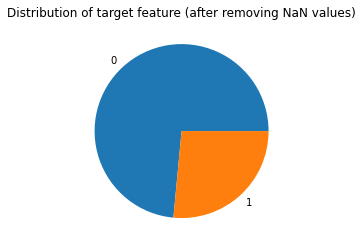

In [23]:
# removing lines with NaN values
df_auto_train_reduced = df_auto_train.dropna()   #(inplace=True)

# checking reduced dataset size
print(df_auto_train_reduced.shape)

# distribution of target features in reduced dataset
plt.pie(df_auto_train_reduced["TARGET_FLAG"].value_counts(), labels = [0,1])
plt.title('Distribution of target feature (after removing NaN values)')
plt.show()

Although the proportions per columns of NaN were relatively small, removing the samples with at least one NaN value reduced the size of training dataset by about 25%. The distribution of the target feature in this reduced dataset remains the same. Also, it is about 2.8 times the size of the test set (which is made of 2141 samples) so we consider its size to be sufficient to train an algorithm. Nevertheless, it would be better to avoid reducing the dataset by 25% and instead fill missing values.

#### III.4) b) Fill missing values

Among the 6 features with missing values, 5 are numerical and 1 categorical. The numerical features will be filled with the median value of these features over whole dataset, while the categorical feature will be filled with the most represented value.

In [24]:
# copy train dataframe
df_train_filled = df_auto_train.copy()

# replace NaN with median for numerical features :
for num_feat in numerical_features:
    df_train_filled[num_feat].fillna(df_train_filled[num_feat].median(), inplace = True)

# replace NaN with most represented value for categorical features :
for cat_feat in categorical_features:
    cat_most = df_train_filled[cat_feat].value_counts().idxmax()
    df_train_filled[cat_feat].fillna(cat_most, inplace = True)

## IV.) EXPLORATORY DATA ANALYSIS

In this section, we want to see how features are distributed and also how the target is distributed among them. We hope to get  some insight on features' predictive power, allowing us to remove non predictive features. We also look at the correlation between features for the same purpose.

### IV.1) Categorical features

We want to see how the categorical features are distributed across their values, and how the target differs across categorical values. For a given feature, we visualize in a bar graph the proportion of each categorical value, and their corresponding proportions of target. This is implemented in function `bar_chart`. To be more specific on the target distribution, we compute the proportions of the target in each categorical value with the function `target_props`.

In [25]:
def target_props(feature, target, df):
    # function to compute the percentages of target = 1 in each category of a given feature
    # inputs : - df : dataframe
    #          - feature (str) : a key of dataframe df
    #          - target (str) : key of dataframe df corresponding to the target binary feature
    # output : target_percentages = sorted dictionary where keys are categorical values, and associated values are the proportions
    #                               of target = 1 in this category
    
    # Groupby the categorical feature
    temp_df = df.groupby([feature, target]).size().reset_index()
    # Get each category of the feature
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    target_percentages = {}
    # Compute proportions of target = 1 in each category
    for category in categories:
        target_prop = float(temp_df[(temp_df[feature]==category) & (temp_df[target]==1)][0] / temp_df[(temp_df[feature]==category)][0].sum())
        target_percentages[category] = target_prop
    #sort dictionary by ascending order of values
    target_percentages = dict(sorted(target_percentages.items(), key=lambda x:x[1])) # sort dictionary by values
    return target_percentages

In [26]:
for feature in categorical_features:
    print('Proportions for '+ feature, target_props(feature, 'TARGET_FLAG', df_train_filled))

Proportions for PARENT1 {'no': 0.23673066064370413, 'yes': 0.44196843082636955}
Proportions for MSTATUS {'yes': 0.2151614221495709, 'no': 0.3367003367003367}
Proportions for SEX {'m': 0.25382989963021657, 'f': 0.27245714285714284}
Proportions for EDUCATION {'phd': 0.1717032967032967, 'masters': 0.19722557297949336, 'bachelors': 0.23327386262265834, '<high school': 0.3200332502078138, 'high school': 0.340343347639485}
Proportions for JOB {'doctor': 0.11788617886178862, 'manager': 0.13866396761133604, 'lawyer': 0.18323353293413175, 'professional': 0.22112802148612354, 'home maker': 0.28081123244929795, 'clerical': 0.29189614476789927, 'blue collar': 0.32752020416843897, 'student': 0.37359550561797755}
Proportions for CAR_USE {'private': 0.21551052221356196, 'commercial': 0.3456586332122813}
Proportions for CAR_TYPE {'minivan': 0.1627039627039627, 'panel truck': 0.26331360946745563, 'van': 0.268, 'suv': 0.2955536181342633, 'pickup': 0.31893448524118073, 'sports car': 0.33517089305402425}


Some features show significant variations of target across their values. For example, the proportion of target value being equal to 1 is nearly 4.5 higher in the urban environment compared to the rural environment, and nearly twice as big when the `REVOKED` or `PARENT1` feature is 'yes' compared to 'no'. `EDUCATION`, `JOB`, `CAR_TYPE` show important variations as well as the ratio between the highest percentage across categories to lowest is higher than 2. For `MSTATUS`, `CAR_USE`, this ratio is approximately 1.5. This indicates that these features may all be predictive for the target feature.
However, the target feature is evenly distributed across `RED_CAR` and `SEX` categories, indicating that these two features are not predictive for the target feature.

For a more graphical visualization, one can use the following function. It is applied below to the `CAR_TYPE` feature, allowing us to see that this feature is not equally distributed across its values. That is the case for all categorical features except `SEX` which is nearly balanced between its two values 'f' and 'm'.

In [27]:
def bar_chart(feature, target, df):
    # function to visualize in a bar graph the percentages of target = 1 in each category of a given feature
    # inputs : - df : dataframe
    #          - feature (str) : a key of dataframe df
    #          - target (str) : key of dataframe df corresponding to the target binary feature
    # output : plots a bar graph representing proportions of each categories of the feature and distribution of target feature
    
    # Groupby the categorical feature
    temp_df = df.groupby([feature, target]).size().reset_index()
    # Calculate the value counts of each category of the feature
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    # Calculate the proportion of each category of the feature
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = np.array([round(element * 100,1) for element in div_list])
    # Calculate the proportion of the target feature in each category of the feature
    n = len(categories)
    target_percentages = np.zeros(n)
    for k in range(n):
        category = categories[k]
        target_prop = float(temp_df[(temp_df[feature]==category) & (temp_df[target]==1)][0] / temp_df[(temp_df[feature]==category)][0].sum())
        target_percentages[k] = target_prop
    # Bar graph
    fig = plt.figure(figsize = (6,4))      
    ax = fig.add_subplot(111)
    ind = np.arange(len(percentage))     # positions for bar graph
    width = 0.5                          # width of bars
    ax.bar(ind, percentage, width = width, label =' target 0')    
    ax.bar(ind, percentage*np.array(target_percentages), width = width, label ='target 1')
    plt.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(categories)
    ax.set_ylabel("Proportion")
    plt.title('Proportions of each categories of feature '+ feature + ' and distribution of target feature')
    plt.show()

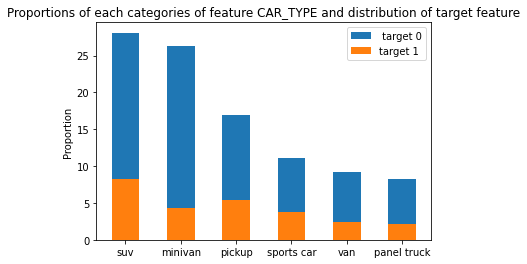

In [28]:
# exemple of visualization for the CAR_TYPE feature
bar_chart('CAR_TYPE', 'TARGET_FLAG', df_auto_train)

### IV.2) Numerical features

Similarly to the previous section, we want to see how the numerical features are distributed across their values, and how the distributions differ considering the target feature. We will compare the distributions of numerical variables between samples with target = 0 and target = 1. The aim is not to accurately determine feature importance but to get insights on how each feature is distributed and to see if, for a given feature, the distributions corresponding to target value equal to 0 or to 1 show different tendencies which would indicate that the feature is predictive for the target.

We thus start by defining a function `hist_numerical_feat` to plot these distributions for a given numerical feature.

In [29]:
def hist_numerical_feat(feature, target, df):
    # function to plot the distribution of a feature per target value
    # inputs : - df : dataframe
    #          - feature (str) : a key of dataframe df
    #          - target (str) : key of dataframe df corresponding to the target binary feature
    # output : plots a histogram representing distributions of the feature and distribution for each target feature value (0 or 1)
    
    plt.hist(list(df[df[target]==0][feature]), bins = 50, color = 'b', alpha = 0.6, label = 'target 0')
    plt.hist(list(df[df[target]==1][feature]), bins = 50, color = 'r', alpha = 0.6, label = 'target 1')
    plt.legend()
    plt.title('Distributions of feature '+feature+' per target value')
    plt.show()

We analysed the distributions of all numerical features, but only represent 3 of them here for more readability : `AGE`, `BLUEBOOK`, `YOJ`. Is it hard to assess the predictive power from the distributions. Still we can look at the approximate position of the peaks of the distributions. In the three examples represented below, the peaks of the two distributions for the `BLUEBOOK` and `AGE` features seem distinct, while they seem very close for the `YOJ` feature. This suggests that `BLUEBOOK` and `AGE` have higher predictive power than `YOJ`. 

From this comparison between distribution peaks, it seems that among the other numerical features `KIDSDRIV`, `HOMEKIDS`, `TRAVTIME`, `TIF`, `CAR_AGE` have poor predictive power, while the rest have better predictive power. (`INCOME`, `HOME_VAL`, `OLDCLAIM`, `CLM_FREQ`, `MVR_PTS`). Nevertheless it remains hard to quantify their predictive power from these histograms and prefer not to discard any feature from this analysis.

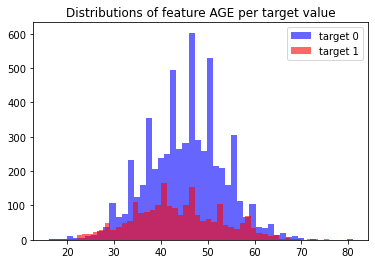

In [30]:
# feature AGE
hist_numerical_feat('AGE', 'TARGET_FLAG', df_train_filled)

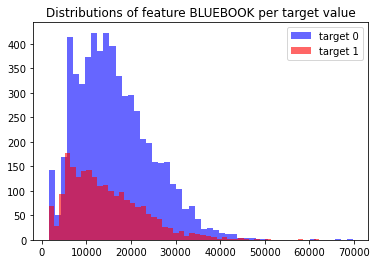

In [31]:
# feature BLUEBOOK
hist_numerical_feat('BLUEBOOK', 'TARGET_FLAG', df_train_filled)

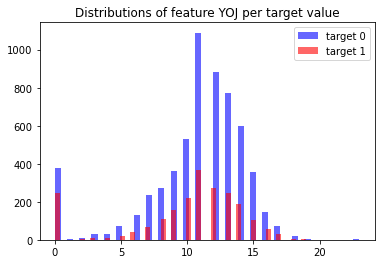

In [32]:
# feature YOJ
hist_numerical_feat('YOJ', 'TARGET_FLAG', df_train_filled)

### IV.3) Feature correlation

To analyse feature correlation, since we have both numerical and categorical values, we looked for a measure of association between two categorical features. A solution found was Cramér's V, a measure of association between two nominal variables, based on Pearson's chi-squared statistic and giving a value between 0 and 1. An implementation of the method was found in <a>https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9</a> with the function `cramers_v`.

In [33]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Using this function, we compute a correlation matrix with `correlation_matrix`.

In [34]:
def correlation_matrix(df, features_list, nb_features):
    # function to compute the correlation matrix using the method Cramér's V 
    # inputs : - df = dataframe 
    #          - features_list = list of keys corresponding to features to select in dataframe df 
    #          - nb_features (int) = length of features_list
    # output : corr_matrix = array of (size nb_features x nb_features) giving the correlation values between the 
    #                        features in features_list
    
    corr_matrix = np.zeros((nb_features,nb_features))
    for i in range(nb_features):
        feature_i = features_list[i]
        for j in range(nb_features):
            feature_j = features_list[j]
            corr = cramers_v(df_auto_train[feature_i],df_auto_train[feature_j] )
            corr_matrix[i,j] = corr
            corr_matrix[j,i] = corr
    return corr_matrix

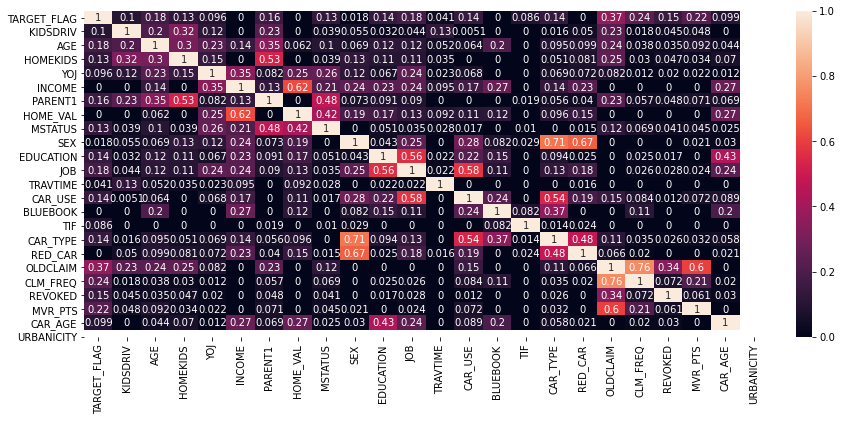

In [35]:
# correlation between our 23 features and target
corr_matrix = correlation_matrix(df_train_filled, ['TARGET_FLAG']+features_list, nb_features)
# visualization of the correlation matrix
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.heatmap(corr_matrix, annot=True, xticklabels = ['TARGET_FLAG']+features_list, yticklabels = ['TARGET_FLAG']+features_list)

We can see some coherent correlations between for example `INCOME` and `HOME_VAL` or `JOB` and `CAR_USE`. It is interesting to see that the target has the highest correlation with features relative to previous claims `OLDCLAIM`and `CLM_FREQ`.

Considering how the target was evenly distributed across `SEX` and `RED_CAR` features (which are also correlated), we decide not to take them into account for training. This leaves us with 21 features, which we all decide to keep because it is hard to assess precisely their predictive power from the exploraty feature analysis.

## V) MODEL TRAINING

### V.1) Prepare the data for model training

First, we make some final transformations on the dataset to prepare it for training. This includes encoding all features as numbers, scaling numerical features, and spliting the dataset in train/validation.

#### V.1) a) Numerical encoding of categorical features

We need to transform categorical data into numbers. To do so, we use `LabelEncoder` from `sklearn`, which turns string into incremental value. We also store the transformations in a dictionary so we can later apply the same transformations to the test set (this relies on the hypothesis that all categorical values in the test set are seen in the train set).

In [36]:
# encoding categorical features using LabelEncoder()
cat_feat_le = {}                           # dictionary to store encoder for each categorical feature
for cat_feat in categorical_features:
    le = preprocessing.LabelEncoder()
    le.fit(df_train_filled[cat_feat])
    df_train_filled[cat_feat] = le.transform(df_train_filled[cat_feat])
    cat_feat_le[cat_feat] = le

# update features types
features_type = df_auto_train.dtypes

#### V.1) b) Scaling numerical features

We also scale the numerical features using `StandardScaler`.

In [38]:
# normalizing numerical features
scaler = preprocessing.StandardScaler()
df_train_filled[numerical_features] = scaler.fit_transform(df_train_filled[numerical_features])

#### V.1) c) Separation train/validation

We separate the dataset into train / validation sets with respective proportions of 80% / 20 %. We use the `train_test_split` function from `sklearn`, which respects equal proportions of target classes in the train and validation sets.

In [39]:
# features selected for training
features_select = features_list.copy()
features_select.remove('SEX')
features_select.remove('RED_CAR')

X = df_train_filled[features_select]  # input features
y = df_train_filled['TARGET_FLAG']    # input target

# split train / validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y)
print("Number of samples in training set: ", X_train.shape[0])
print("Number of samples in validation set:", X_val.shape[0])
print('Proportion of target 1 in the training set:', round(y_train.value_counts().min()/ y_train.value_counts().sum(),2))
print('Proportion of target 1 in the validation set:', round(y_val.value_counts().min()/ y_val.value_counts().sum(),2))

Number of samples in training set:  6528
Number of samples in validation set: 1633
Proportion of target 1 in the training set: 0.26
Proportion of target 1 in the validation set: 0.26


As seen at the beginning of this work, the target is unbalanced. We will train a first algorithm with this dataset. Considering it is unbalanced, it's important not to look only at the accuracy score to evaluate our model. We propose to look at the four following metrics: accuracy , precision , recall , and f1 score. In particular for this unbalanced dataset, we will pay attention to recall and f1 metrics.

### V.2) Model training (unbalanced dataset)

#### V.2) a) Model training functions

In this section we implement the function `train_model` that will be used to train 3 types of machine learning algorithms :
- Logistic Regression
- Random Forest
- Support-Vector Machine (SVM)

To evaluate the model performance, we use `print_scores`that displays the accuracy, precision, recall, and f1 scores and `plot_mat_conf` which allows to visualize the confusion matrix.

In [40]:
def print_scores(alg_name, y_true, y_pred):
    # function to compute and print 4 metrics scores to evaluate the performance of an algorithme
    # inputs : - alg_name (str): the name of algorithm
    #          - y_true (array): ground truth target values
    #          - y_pred (array): Estimated targets as returned by the algorithm
    
    print(alg_name)
    acc_score = accuracy_score(y_true, y_pred)      # accuracy
    print("accuracy: ",acc_score)
    pre_score = precision_score(y_true, y_pred)     # precision
    print("precision: ",pre_score)
    rec_score = recall_score(y_true, y_pred)        # recall                        
    print("recall: ",rec_score)
    f_score = f1_score(y_true, y_pred)              # f1
    print("f1_score: ",f_score)

In [41]:
def plot_conf_mat(y_test, y_pred):
    # function to compute and plot a confusion matrix
    # inputs : - y_true (array): ground truth target values
    #          - y_pred (array): Estimated targets as returned by the algorithm
    
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    # plot parameters
    labels = ['Class 0', 'Class 1']
    fig = plt.figure(figsize = (4,4))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

In [42]:
def train_model(alg, alg_name, X_train, X_val, y_train, y_val, params={}):
    # function to train a classifier, print its performance on 4 metrics and plot its confusion matrix
    # inputs : - alg : classifier method
    #          - alg_name (str): the name of algorithm
    #          - X_train (array-like): training input samples
    #          - X_val (array-like): validation input samples
    #          - y_train (array-like): training target values
    #          - y_val (array-like): validation target values
    #          - params (dict): parameters for classifier
    
    # Instantiating the algorithm class and unpacking parameters if any
    model = alg(**params) 
    # train model
    model.fit(X_train, y_train)
    # Prediction on validation set and corresponding scores
    y_pred = model.predict(X_val)
    print_scores(alg_name, y_val, y_pred)
    plot_conf_mat(y_val, y_pred)
    return model

#### V.2) b) Logistic regression

We start by training a Logistic Regression algorithm on our unbalanced dataset.

Logistic Regression
accuracy:  0.7985303123086344
precision:  0.6821428571428572
recall:  0.4431554524361949
f1_score:  0.5372714486638537


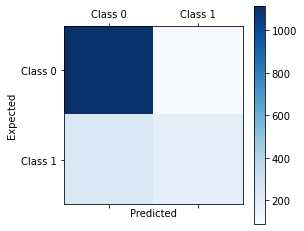

In [43]:
log_model = train_model(LogisticRegression, 'Logistic Regression', X_train, X_val, y_train, y_val)

As we see on this first training, the accuracy score is good with 78% but f1 score is about 50%. Because our dataset is heavily unbalanced, the algorithm tends to label all samples with class 0, leading to important false negative rate and thus low recall (40%) and f1 score while keeping high accuracy. 

We propose to downsample the dataset in order to have balanced classes.

### V.3) Model training (balanced dataset)

#### V.3) a) Downsampling

We implement the following function `downsample`to downsample our dataset in order to have balanced classes. We apply it to our dataset and split again train / validation with proportions 80% / 20%. We then train our three types of algorithms.

In [87]:
def downsample(df, target):
    # function to under-sample a training set in which the binary target is unbalanced
    # inputs : - df : training dataset
    #          - target (str): key of the binary target feature
    # output : df_train_under : downsampled dataframe with balanced target
    
    # class count
    count_class_0, count_class_1 = df[target].value_counts()
    # divide by class
    df_class_0 = df[df[target] == 0]
    df_class_1 = df[df[target] == 1]
    # random downsampling
    if count_class_0 > count_class_1 :
        df_class_0_under = df_class_0.sample(count_class_1)
        df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)
    else:
        df_class_1_under = df_class_1.sample(count_class_0)
        df_train_under = pd.concat([df_class_1_under, df_class_0], axis=0)
    # print new class count
    print('Random under-sampling:')
    print(df_train_under[target].value_counts())
    return df_train_under

In [88]:
# downsample our training dataset
df_train_under = downsample(df_train_filled, 'TARGET_FLAG')
X_under = df_train_under[features_select]
y_under = df_train_under['TARGET_FLAG']

#new split train / validation
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_under, y_under, test_size=0.2)

Random under-sampling:
1    2153
0    2153
Name: TARGET_FLAG, dtype: int64


#### V.3) b) Logistic regression

We train a Logistic Regression algorithm on this balanced dataset.

Logistic Regression
accuracy:  0.7470997679814385
precision:  0.7297297297297297
recall:  0.7677725118483413
f1_score:  0.7482678983833718


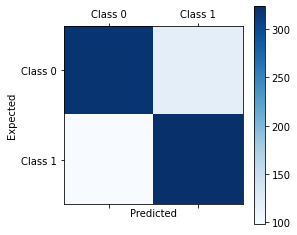

In [89]:
log_model = train_model(LogisticRegression, 'Logistic Regression', X_train_under, X_val_under, y_train_under, y_val_under)

With this balanced dataset, we have much better recall and f1 score than on the unbalanced dataset. 
Let's look now at the two other classifiers Random Forest and SVM.

#### V.3) c) Random Forest

Random Forest Classification
accuracy:  0.7459396751740139
precision:  0.720173535791757
recall:  0.7867298578199052
f1_score:  0.7519818799546999


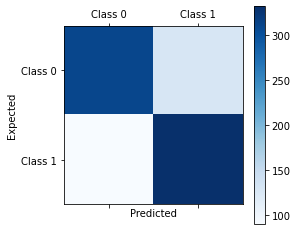

In [96]:
rm_fr = train_model(RandomForestClassifier, "Random Forest Classification", X_train_under, X_val_under, y_train_under, y_val_under, params={'n_estimators' : 500})

#### V.3) d) SVM

SVC Classification
accuracy:  0.7470997679814385
precision:  0.7328767123287672
recall:  0.7606635071090048
f1_score:  0.7465116279069769


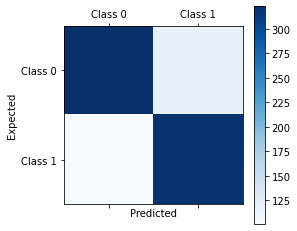

In [97]:
svc_model = train_model(SVC, 'SVC Classification', X_train_under, X_val_under, y_train_under, y_val_under)

All three algorithms give similar performances. Now that the trainset is balanced, we consider in priority the accuracy and precision score to assess the models. On the first test we performed, Logistic Regression and SVM  classifiers gave slightly bigger accuracy and precision scores than Random Forest. However, this is the result of a single train and is not sufficient to assess the effectiveness of our models. That is why we will now perform cross validation. 

### V.4) Cross validation

We implement a function `cross_validation` to perform the cross validation, print the average score and standard deviation and return the classifier with best score. We apply it on our three classifiers.

In [49]:
def cross_validation(alg, alg_name, X, y, cv, score_metrics, params={}):
    # function to perform cross validation on the train set and print performance
    # inputs : - alg : classifier method
    #          - alg_name (str): the name of algorithm
    #          - X (array-like): training input samples
    #          - y (array-like): training target values
    #          - cv : number of folds for cross validation
    #          - score_metrics (list) : list of metrics to evaluate model
    #          - params (dict): parameters for classifier
    
    model = alg(**params)
    scores = cross_validate(model, X, y, cv=cv, scoring = score_metrics, return_estimator=True)
    print(alg_name)
    for metric in score_metrics:
        mean = scores['test_'+metric].mean()
        std = scores['test_'+metric].std()
        print(str(mean)+' '+metric+ " with a standard deviation of "+ str(std))

#### V.4) a) Logistic regression

In [99]:
cross_validation(LogisticRegression, 'Logistic Regression', X_under, y_under, 10, ['accuracy','precision','recall','f1'])

Logistic Regression
0.7259558625155129 accuracy with a standard deviation of 0.01790351147301109
0.7179023470168888 precision with a standard deviation of 0.018136658015917868
0.7450258397932816 recall with a standard deviation of 0.028435360634745884
0.7309461337301987 f1 with a standard deviation of 0.018887881950851282


#### V.4) b) Random Forest

In [100]:
cross_validation(RandomForestClassifier, "Random Forest Classification", X_under, y_under, 10, ['accuracy','precision','recall','f1'],  params={'n_estimators' : 500})

Random Forest Classification
0.7243333513192683 accuracy with a standard deviation of 0.01924817198872189
0.7093580092172782 precision with a standard deviation of 0.018393896319270898
0.7608053402239449 recall with a standard deviation of 0.03529947953364987
0.7337726418907861 f1 with a standard deviation of 0.02109985960088567


#### V.4) c) SVM

In [101]:
cross_validation(SVC, 'SVC Classification', X_under, y_under, 10, ['accuracy','precision','recall','f1'])

SVC Classification
0.7278228025683915 accuracy with a standard deviation of 0.01681237532093262
0.7163340968240759 precision with a standard deviation of 0.015189395021158679
0.7547739018087856 recall with a standard deviation of 0.031214108202390844
0.7347460297146353 f1 with a standard deviation of 0.018722787593809905


### V.5) Choice of model

As said before, the cross validation was performed on a balanced downsampled training set so we consider in priority the accuracy and precision metric to assess which is the best model. Although the three models have similar performances, SVM has a slightly better average accuracy with smaller standard deviation than the others. Its average precision is slightly smaller than the one of Logistic regression but has smaller standard deviation. Also, generally the risk of overfitting is more important with Logistic regression than SVM. As a result, we select the SVM model. As a final step of training, we train a SVM over the whole downsampled train set.

In [126]:
# train selected model over whole downsampled training set
best_model = SVC()
best_model.fit(X_under, y_under)

SVC()

## VI) Prediction on the test set

In this final section, we will make predictions on the test set using the previously trained model.

### VI.1) Preprocessing

We start by applying the same preprocessing operations as done for the training set :
- converting all numerical features to numbers (dealing with $ signs)
- replacing negative values of numerical features by their absolute value
- removing 'z_' characters at the beginning of strings for categorical features
- putting all characters in lower case for categorical features
- fill missing values with median (median computed on the training set) for numerical features
- fill missing values with most represented value (computed on the training set) for categorical features
- encode categorical features as numbers using the same tranformation as used for the train set
- normalize numerical features using the same transformation as the train set

In [127]:
# get the test set and remove non features columns
df_test = df_auto_test.drop('TARGET_FLAG',axis = 1)
df_test.drop('TARGET_AMT',axis = 1, inplace = True)

# transform numerical features with $ signs to float
for key in ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']:
    df_test[key] = df_test[key].transform(lambda x : convert_to_float(x))

# replacing negative values for numerical features by their absolute values
for num_feat in numerical_features:
    df_test[num_feat] = df_test[num_feat].transform(lambda x : abs(x) if x<0 else x)

#removing potential 'z_' characters in the categorical features and put all characters in lower case
for cat_feat in categorical_features:
    df_test[cat_feat] = df_test[cat_feat].transform(lambda x : remove_z(x))
    df_test[cat_feat] = df_test[cat_feat].str.lower()

In [128]:
#fill NaN values of numerical features with median computed on train set
for num_feat in numerical_features:
    df_test[num_feat].fillna(df_auto_train[num_feat].median(), inplace = True)

#fill NaN values of categorical features with most represented category computed on train set
for cat_num in categorical_features:
    cat_most = df_auto_train[cat_num].value_counts().idxmax()
    df_test[cat_num].fillna(cat_most, inplace = True)

In [129]:
# encode categorical features as numbers using transformation of train set
for cat_feat in categorical_features:
    df_test[cat_feat] = cat_feat_le[cat_feat].transform(df_test[cat_feat])
    
# normalize numerical features using transformation of train set
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

### VI.2) Prediction

Now that the dataset set is ready, we finish by taking only the 21 features among the 23 we selected for training and use the model to make the prediction.

In [130]:
# select 21 features
X_test = df_test[features_select]

In [131]:
# prediction with best model
y_test_pred = best_model.predict(X_test)

In [132]:
# save prediction with corresponding index in a csv
df_predictions = pd.DataFrame(columns=['INDEX', 'TARGET_PRED'])
df_predictions['INDEX'] = df_auto_test['INDEX']
df_predictions['TARGET_PRED'] = y_test_pred
# save in csv
df_predictions.to_csv("test_predictions.csv")

In [133]:
df_predictions['TARGET_PRED'].value_counts()

0    1190
1     951
Name: TARGET_PRED, dtype: int64

The predictions have been saved in a csv file `test_predictions` with a column with claims `Index` and corresponding prediction in the column `TARGET_PRED`. 

### Conclusion

To conclude this work, we had at our disposal labelled auto insurance data that allowed us to train three machine learning algorithm and select best model to make predictions on an unlabelled test set. 

We made various preprocessing transformations on the dataset to fill missing values, harmonize notations, and encode all features as numbers for training. Analyzing feature distributions gave insights on features' predictive power and led us to cast out two categorical features, resulting in a total of 21 features given as inputs to the algorithms.

The dataset was significantly unbalanced and a first training highlighted the need to have more balanced classes. That is why we chose to downsample the dataset. This nearly divided by two dataset, and led to a training dataset of about  twice the size of test set. We considered it sufficient to train and algorithm and make predictions on the test set but it risks leading to important false positive rate and we also fear overfitting. For instance, we see that the proportion of class 1 predicted on the test set is about 44%, about 1.7 times the proportion in the whole train set.
It would have been better to find data augmentation techniques to create more samples of class 1, and we propose this as one further improvement to this work.

Finally, we trained three types of classifiers : Logistic Regression, Random Forest, SVM. We assessed their performance with the accuracy and precision metrics since we worked on the downsampled balanced dataset. Using cross validation, SVM and Logistic Regression showed similar performances, better than Random Forest. SVM performed slightly better and we chose this model to make predictions on the test set.

To further improve to this work, it would be interesting to analyse feature importance to see if non predictive features were left and could be cast out. It would also be interesting to optimize model parameters.